<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/transfer_learning_using_pre_trained_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
We are using tranfer learning for mobilenetv2 to train a neural network. We will use a pre-trained mobilenetv2 model with the trained weight (imagenet), and do not freeze the weight. As a result, it can give a very good accuracy (about 99%).  

## 1. Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mounted at /content/drive

In [2]:
!ls "/content/drive/My Drive/Garbage classification/"

cardboard  glass  metal  paper	plastic  trash


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Add, Reshape, DepthwiseConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import glob, os, random
import numpy as np
import matplotlib.pyplot as plt

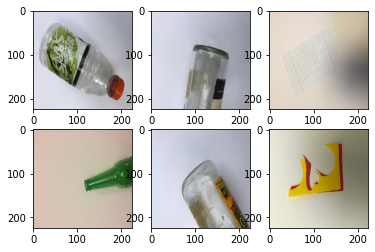

In [4]:
from keras.preprocessing import image
base_path = '/content/drive/My Drive/Garbage classification'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size= 32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size= 32,
    class_mode='categorical',
    subset='validation',
    seed=0
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [6]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 6))

In [7]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)



{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [8]:
!ls

drive  labels.txt  sample_data


In [9]:
path = 'labels.txt'
label = np.array(open(path).read().splitlines())

##2. Import MobileNetV2 

In [10]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


### 2.1 Transfer learning with frozen weights

In [11]:
# Freeze all the layers before the `fine_tune_at` layer
base_model.trainable = False

for layer in  base_model.layers:
    print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f076fae49e8>: False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f076f8295c0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f076f8297f0>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f076f7bd860>: False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f076f7e19b0>: False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f076f7e1390>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f076f6fd6d8>: False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f076f71aa20>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f076f6aa9e8>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f076f6a2748>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f

In [ ]:
#from tensorflow import keras
#model = tf.keras.Sequential([
#  base_model,
#  keras.layers.GlobalAveragePooling2D(),
#  keras.layers.Dense(6, activation='sigmoid')
#])

In [15]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         1474688   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 3,733,446
Trainable params: 1,475,462
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), #RMSprop(lr=0.0001),  
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
batch_size = 32
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/50
71/71 [==============================] - 113s 2s/step - loss: 1.9473 - acc: 0.5793 - val_loss: 0.7022 - val_acc: 0.7277
Epoch 2/50
71/71 [==============================] - 114s 2s/step - loss: 0.6982 - acc: 0.7398 - val_loss: 0.5596 - val_acc: 0.7634
Epoch 3/50
71/71 [==============================] - 113s 2s/step - loss: 0.6038 - acc: 0.7919 - val_loss: 0.5037 - val_acc: 0.7991
Epoch 4/50
71/71 [==============================] - 114s 2s/step - loss: 0.5384 - acc: 0.8004 - val_loss: 0.5123 - val_acc: 0.8259
Epoch 5/50
48/71 [===================>..........] - ETA: 35s - loss: 0.4428 - acc: 0.8369

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### Transfer Learning with trainable weights

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

for layer in  model.layers:
    print("{}: {}".format(layer, layer.trainable))

In [ ]:
#model.compile(loss='binary_crossentropy',
 #             optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
  #            metrics=['accuracy'])
#model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
history_fine = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps) 

In [ ]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()